<a href="https://colab.research.google.com/github/dansojo/Medical_CV/blob/main/mask%EC%83%9D%EC%84%B1(AttentionUNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

In [ ]:
class Config:
    DATA_DIR = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/main(A,B)/A(train)/images"
    MASKS_DIR = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/main(A,B)/A(train)/masks"
    METADATA_DIR = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/HAM10000_metadata"
    SAVE_MODEL_DIR = "/content/drive/MyDrive/Medical_CV//피부암 분류 및 Segmentation/part3_datasets"
    SAVE_MASKS_DIR = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/main(A,B)/B(test)/mask이미지(Segmentation_AttentionUNet)"
    TEST_DIR = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/main(A,B)/B(test)/images"
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    NUM_CLASSES = 1  # Binary Segmentation
    EPOCHS = 20
    LR = 1e-5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, metadata, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.metadata = metadata
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # 이미지 경로 설정
        img_name = self.metadata.iloc[idx]['image_id']
        image_path = os.path.join(self.image_dir, img_name + ".jpg")
        mask_path = os.path.join(self.mask_dir, img_name + "_segmentation.png")

        # 이미지와 마스크 로드
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale로 로드

        # 마스크 이진화 (NumPy 배열로 변환 후 0과 1로 구성)
        mask = np.array(mask)
        mask = (mask > 128).astype(np.float32)  # 이진화 수행

        # 변환 적용
        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(Image.fromarray(mask * 255))  # NumPy 배열을 PIL 이미지로 변환 후 적용

        # 마스크 채널 차원 추가 (필요한 경우)
        if len(mask.shape) == 2:
            mask = torch.unsqueeze(torch.tensor(mask), dim=0)

        return image, mask


In [ ]:
def split_data(metadata_path, image_dir):
    # 메타데이터 로드
    metadata = pd.read_csv(metadata_path)

    # 실제 파일과 매칭
    image_files = set([f.split('.')[0] for f in os.listdir(image_dir)])
    metadata = metadata[metadata['image_id'].isin(image_files)]

    # 데이터 분할 (7:1.5:1.5)
    train_data, temp_data = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata['dx'])
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['dx'])

    return train_data, val_data, test_data

In [ ]:
def get_data_transforms():
    # 이미지에만 적용할 변환 (정규화 포함)
    image_transform = T.Compose([
        T.Resize(Config.IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    # 마스크에만 적용할 변환 (정규화 없음)
    mask_transform = T.Compose([
        T.Resize(Config.IMAGE_SIZE),
        T.ToTensor()  # 이진 마스크는 [0, 1] 범위로 변환됨
    ])

    return image_transform, mask_transform

In [ ]:
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [ ]:
# 2D Attention U-Net
class AttentionUNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(AttentionUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder with attention
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = self.conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = self.conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = self.conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with attention
        dec4 = self.up4(bottleneck)
        att4 = self.att4(dec4, enc4)
        dec4 = self.dec4(torch.cat([dec4, att4], dim=1))

        dec3 = self.up3(dec4)
        att3 = self.att3(dec3, enc3)
        dec3 = self.dec3(torch.cat([dec3, att3], dim=1))

        dec2 = self.up2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = self.dec2(torch.cat([dec2, att2], dim=1))

        dec1 = self.up1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = self.dec1(torch.cat([dec1, att1], dim=1))

        return self.final_conv(dec1)  # sigmoid 제거, BCEWithLogitsLoss 사용 시 필요 없음

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def pool(self, x):
        return nn.MaxPool2d(2, stride=2)(x)

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=20, learning_rate=1e-4, patience=5):
    """
    모델 학습을 수행하는 함수

    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        device: 학습에 사용할 디바이스 (cuda/cpu)
        num_epochs: 학습 에포크 수
        learning_rate: 학습률
        patience: Early stopping을 위한 patience 값

    Returns:
        model: 학습된 모델
        best_model_state: 가장 좋은 성능을 보인 모델의 가중치
        history: 학습 히스토리
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()  # 손실 함수: BCEWithLogitsLoss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    # 학습 관련 변수 초기화
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': []
    }

    print("Starting training process...")
    print(f"Training on device: {device}")

    for epoch in range(num_epochs):
        # ----------------------
        # Training phase
        # ----------------------
        model.train()
        train_loss = 0.0
        train_intersection = 0
        train_union = 0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # 손실값 및 Dice coefficient 계산
            train_loss += loss.item()
            predicted_masks = (outputs > 0).float()  # BCEWithLogitsLoss 사용 시 0 기준
            intersection = (predicted_masks * masks).sum()
            union = predicted_masks.sum() + masks.sum()
            train_intersection += intersection.item()
            train_union += union.item()
            train_batches += 1

            # 프로그레스바 업데이트
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{(2 * intersection / (union + 1e-8)).item():.4f}'
            })

        avg_train_loss = train_loss / train_batches
        avg_train_dice = (2 * train_intersection) / (train_union + 1e-8)

        # ----------------------
        # Validation phase
        # ----------------------
        model.eval()
        val_loss = 0.0
        val_intersection = 0
        val_union = 0
        val_batches = 0

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')

            for images, masks in progress_bar:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                predicted_masks = (outputs > 0).float()
                intersection = (predicted_masks * masks).sum()
                union = predicted_masks.sum() + masks.sum()
                val_intersection += intersection.item()
                val_union += union.item()
                val_batches += 1

                progress_bar.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'val_dice': f'{(2 * intersection / (union + 1e-8)).item():.4f}'
                })

        avg_val_loss = val_loss / val_batches
        avg_val_dice = (2 * val_intersection) / (val_union + 1e-8)

        # 히스토리 업데이트
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_dice'].append(avg_train_dice)
        history['val_dice'].append(avg_val_dice)

        # 결과 출력
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")

        # 학습률 스케줄러 호출
        scheduler.step(avg_val_loss)

        # 최적 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
            print(f"Best model updated at epoch {epoch+1}")
        else:
            early_stopping_counter += 1

        # Early stopping 체크
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        # 중간 체크포인트 저장 (5 에포크마다)
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(
                Config.SAVE_MODEL_DIR,
                f'checkpoint_epoch_{epoch+1}.pth'
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_dice': avg_train_dice,
                'val_dice': avg_val_dice,
                'history': history
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

    print("Training completed!")
    return model, best_model_state, history


In [ ]:
def save_model(save_dir, model_state, file_name="best_model.pth"):
    """
    모델 가중치를 저장하는 함수.
    """
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, file_name)
    torch.save(model_state, save_path)
    print(f"Model saved to {save_path}")

In [ ]:
# 1. 데이터 분리
train_data, val_data, test_data = split_data(Config.METADATA_DIR, Config.DATA_DIR)
full_data = pd.concat([train_data, val_data, test_data])

# 2. 데이터 로드 및 변환
image_transform, mask_transform = get_data_transforms()

train_dataset = ImageDataset(Config.DATA_DIR, Config.MASKS_DIR, train_data, image_transform, mask_transform)
val_dataset = ImageDataset(Config.DATA_DIR, Config.MASKS_DIR, val_data, image_transform, mask_transform)
test_dataset = ImageDataset(Config.DATA_DIR, Config.MASKS_DIR, test_data, image_transform, mask_transform)
full_dataset = ImageDataset(Config.DATA_DIR,Config.MASKS_DIR, full_data, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

In [ ]:
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")  # 이미지 형태 출력
    print(f"Mask batch shape: {masks.shape}")    # 마스크 형태 출력
    break  # 첫 번째 배치만 출력하고 종료

Image batch shape: torch.Size([16, 3, 224, 224])
Mask batch shape: torch.Size([16, 1, 224, 224])


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# 3. 모델 학습
model = AttentionUNet(input_channels=3, output_channels=1)
trained_model, best_model_state, history = train_model(model, train_loader, val_loader, Config.DEVICE)

# 최적 모델 저장
save_path = os.path.join(Config.SAVE_MODEL_DIR, "best_model_Atten.pth")
torch.save(best_model_state, save_path)
print(f"Best model saved to {save_path}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training process...
Training on device: cuda


Epoch 1/20 [Validation]: 100%|██████████| 85/85 [11:12<00:00,  7.91s/it, val_loss=-181.3257, val_dice=1.9300]



Epoch 1/20:
Train Loss: -205.4007, Train Dice: 1.9085
Val Loss: -323.0346, Val Dice: 1.9717
Best model updated at epoch 1


Epoch 2/20 [Validation]: 100%|██████████| 85/85 [00:46<00:00,  1.81it/s, val_loss=-262.0499, val_dice=1.9511]



Epoch 2/20:
Train Loss: -391.6961, Train Dice: 1.9738
Val Loss: -485.6096, Val Dice: 1.9736
Best model updated at epoch 2


Epoch 3/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.92it/s, val_loss=-435.9875, val_dice=1.8982]



Epoch 3/20:
Train Loss: -596.3744, Train Dice: 1.9741
Val Loss: -785.5256, Val Dice: 1.9752
Best model updated at epoch 3


Epoch 4/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.89it/s, val_loss=-479.2451, val_dice=1.9582]



Epoch 4/20:
Train Loss: -826.6579, Train Dice: 1.9751
Val Loss: -879.5480, Val Dice: 1.9758
Best model updated at epoch 4


Epoch 5/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.91it/s, val_loss=-597.5419, val_dice=1.8327]



Epoch 5/20:
Train Loss: -1084.4846, Train Dice: 1.9754
Val Loss: -1105.5104, Val Dice: 1.9762
Best model updated at epoch 5
Checkpoint saved at epoch 5


Epoch 6/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.91it/s, val_loss=-723.1608, val_dice=1.7563]



Epoch 6/20:
Train Loss: -1367.6658, Train Dice: 1.9757
Val Loss: -1359.3038, Val Dice: 1.9740
Best model updated at epoch 6


Epoch 7/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.90it/s, val_loss=-951.4141, val_dice=1.8557]



Epoch 7/20:
Train Loss: -1674.0300, Train Dice: 1.9766
Val Loss: -1774.1435, Val Dice: 1.9756
Best model updated at epoch 7


Epoch 8/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.88it/s, val_loss=-1074.1561, val_dice=1.9020]



Epoch 8/20:
Train Loss: -2005.0369, Train Dice: 1.9765
Val Loss: -1965.1765, Val Dice: 1.9759
Best model updated at epoch 8


Epoch 9/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.92it/s, val_loss=-1290.6393, val_dice=1.8624]



Epoch 9/20:
Train Loss: -2356.8525, Train Dice: 1.9761
Val Loss: -2481.3777, Val Dice: 1.9772
Best model updated at epoch 9


Epoch 10/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.91it/s, val_loss=-1502.7744, val_dice=1.9328]



Epoch 10/20:
Train Loss: -2730.4293, Train Dice: 1.9773
Val Loss: -2750.8335, Val Dice: 1.9749
Best model updated at epoch 10
Checkpoint saved at epoch 10


Epoch 11/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.88it/s, val_loss=-1620.7640, val_dice=1.8807]



Epoch 11/20:
Train Loss: -3124.5774, Train Dice: 1.9775
Val Loss: -2968.0004, Val Dice: 1.9764
Best model updated at epoch 11


Epoch 12/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.89it/s, val_loss=-1899.9304, val_dice=1.9044]



Epoch 12/20:
Train Loss: -3544.7559, Train Dice: 1.9780
Val Loss: -3573.2624, Val Dice: 1.9768
Best model updated at epoch 12


Epoch 13/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.86it/s, val_loss=-2200.4834, val_dice=1.9698]



Epoch 13/20:
Train Loss: -3980.6637, Train Dice: 1.9782
Val Loss: -4024.1754, Val Dice: 1.9746
Best model updated at epoch 13


Epoch 14/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.88it/s, val_loss=-2515.3206, val_dice=1.9229]



Epoch 14/20:
Train Loss: -4431.4843, Train Dice: 1.9778
Val Loss: -4635.0776, Val Dice: 1.9764
Best model updated at epoch 14


Epoch 15/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.88it/s, val_loss=-2843.9412, val_dice=1.9642]



Epoch 15/20:
Train Loss: -4910.8327, Train Dice: 1.9782
Val Loss: -5064.8294, Val Dice: 1.9768
Best model updated at epoch 15
Checkpoint saved at epoch 15


Epoch 16/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.91it/s, val_loss=-2922.5405, val_dice=1.8450]



Epoch 16/20:
Train Loss: -5410.8442, Train Dice: 1.9789
Val Loss: -5448.7714, Val Dice: 1.9783
Best model updated at epoch 16


Epoch 17/20 [Validation]: 100%|██████████| 85/85 [00:44<00:00,  1.91it/s, val_loss=-2990.0166, val_dice=1.9024]



Epoch 17/20:
Train Loss: -5929.2607, Train Dice: 1.9785
Val Loss: -5493.9829, Val Dice: 1.9783
Best model updated at epoch 17


Epoch 18/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.85it/s, val_loss=-3807.3887, val_dice=1.9219]



Epoch 18/20:
Train Loss: -6456.3572, Train Dice: 1.9789
Val Loss: -6845.5009, Val Dice: 1.9770
Best model updated at epoch 18


Epoch 19/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.86it/s, val_loss=-4012.0198, val_dice=1.9558]



Epoch 19/20:
Train Loss: -7017.0101, Train Dice: 1.9789
Val Loss: -7223.9357, Val Dice: 1.9775
Best model updated at epoch 19


Epoch 20/20 [Validation]: 100%|██████████| 85/85 [00:45<00:00,  1.86it/s, val_loss=-4196.0967, val_dice=1.8725]



Epoch 20/20:
Train Loss: -7592.9298, Train Dice: 1.9790
Val Loss: -7694.3599, Val Dice: 1.9771
Best model updated at epoch 20
Checkpoint saved at epoch 20
Training completed!
Best model saved to /content/drive/MyDrive/Medical_CV//피부암 분류 및 Segmentation/part3_datasets/best_model_Atten.pth


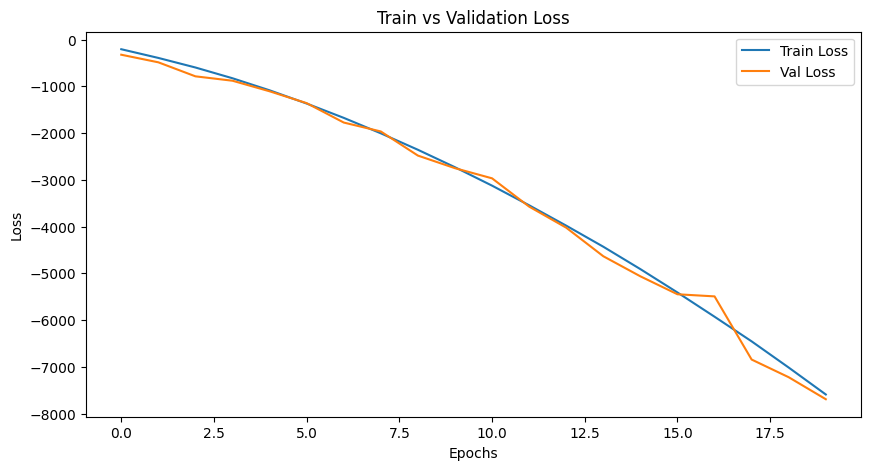

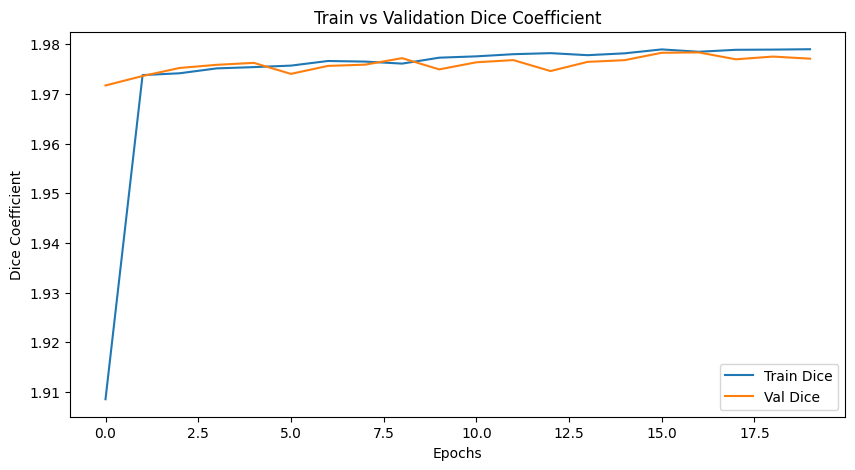

In [ ]:
import matplotlib.pyplot as plt

# Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# Train vs Validation Dice Coefficient
plt.figure(figsize=(10, 5))
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Val Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train vs Validation Dice Coefficient')
plt.legend()
plt.show()


In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")
        image_id = self.image_files[idx].split('.')[0]

        if self.transform:
            image = self.transform(image)

        return image, image_id

In [ ]:
def generate_and_save_masks(model, data_loader, save_dir, device):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating masks"):
            images, image_ids = batch
            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5  # sigmoid 적용 후 이진화

            for pred, img_id in zip(predictions, image_ids):
                mask = pred.squeeze().cpu().numpy() * 255
                mask_path = os.path.join(save_dir, f"{img_id}_generated.png")
                cv2.imwrite(mask_path, mask.astype(np.uint8))

    print(f"Masks saved to {save_dir}")


In [ ]:
# 테스트 이미지 경로
test_image_dir = Config.TEST_DIR

# 변환 정의 (학습에 사용한 것과 동일하게 적용)
test_transform = T.Compose([
    T.Resize(Config.IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# 테스트 데이터셋 및 데이터 로더 생성
test_dataset = TestImageDataset(test_image_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2,
                        pin_memory=True)

# 학습된 모델로 테스트 데이터에 대한 마스크 생성 및 저장
generate_and_save_masks(trained_model, test_loader, Config.SAVE_MASKS_DIR, Config.DEVICE)


Generating masks: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]

Masks saved to /content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/main(A,B)/B(test)/mask이미지(Segmentation_AttentionUNet)
